**Purpose**: Analyze the feedback that are embeded at the end of the tutorials in Galaxy Training Material

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from pprint import pprint
import datetime
import emoji

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1NfZhi5Jav7kl9zFCkeb7rIC2F8xW1isruv1TeO4WpNI/export?format=tsv'

In [3]:
str(datetime.datetime.now())

'2020-09-28 13:29:27.616291'

# Load the feedback

In [4]:
df = (pd.read_csv(url, sep='\t')
    # remove last column
      .drop(['Make feedback confidential?'], axis=1)
    # rename column
      .rename(columns = {'Timestamp': 'timestamp',
                         'How much did you like this tutorial?': 'note',
                         'What did you like?': 'pro',
                         'What could be improved?': 'con',
                         'Tutorial': 'tutorial_topic'}))
# extract topic from tutorial name
new = df.tutorial_topic.str[::-1].str.split('(', n = 1, expand = True)
df["tutorial"]= new[1].str[::-1].str[:-1]
df["topic"]= new[0].str[::-1].str[:-1]
df = (df.drop(columns =["tutorial_topic"])
    # remove rows with NaN on note, pro and con
      .dropna(subset=['note', 'pro', 'con'], how='all')
    # replace NaN in note by 0
      .fillna(value={'note': 0}))
# format note to integer
df.note = df.note.astype(int)
# format pro and con to string
df.pro = df.pro.astype(str)
df.con = df.con.astype(str)
# format timestamp to remove hour and use datetime
df.timestamp = pd.to_datetime(
    df.timestamp.str.split(' ', n = 1, expand = True)[0],
    dayfirst=True)

In [5]:
# change topic for some tutorials
df.loc[df.tutorial == 'Formation of the Super-Structures on the Inactive X', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the Estrogen receptor', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'Identification of the binding sites of the T-cell acute lymphocytic leukemia protein 1 (TAL1)', 'topic'] = 'Epigenetics'
df.loc[df.tutorial == 'RAD-Seq Reference-based data analysis', 'topic'] = 'Ecology'
df.loc[df.tutorial == 'RAD-Seq de-novo data analysis', 'topic'] = 'Ecology'
df.loc[df.tutorial == 'RAD-Seq to construct genetic maps', 'topic'] = 'Ecology'

# Aggregate the feedbacks and notes

In [6]:
def get_notes(df, name):
    '''Aggregage the notes
    
    :df: dataframe with all feedbacks
    
    :return: dataframe object with aggregated notes
    '''
    return (df.note
        .value_counts(sort=False)
        .to_frame()
        .rename(columns= {'note': name}))

In [7]:
notes = get_notes(df, 'All topics')

In [8]:
def get_topic_df(grouped_by_topic, topic, notes):
    '''Extract the dataframe for a topic and plot note histogram
    
    :grouped_by_topic: groupby object grouping by topic
    :topic: topic to extract
    
    :return: dataframe object for the topic
    '''
    topic_df = (grouped_by_topic
        .get_group(topic)
        .drop('topic', 1))
    
    notes = pd.concat([notes, get_notes(topic_df, topic)], axis=1)
    return topic_df, notes


def extract_tutorial_feedbacks(topic_df, topic_name):
    '''Extract pro/con per tutorial for a topic and 
    write them in a file
    
    :topic_df: dataframe object for the topic
    :topic_name: name for the topic, name for the file
    '''
    grouped_by_tuto = topic_df.groupby(by="tutorial")
    with open('../results/%s.md' % topic_name, 'w') as f:
        for tuto, group in grouped_by_tuto:
            # get groups
            tuto_df = grouped_by_tuto.get_group(tuto)
            pros = []
            cons = []
            # get pros/cons
            for index, row in tuto_df.iterrows():
                if row['pro'] != 'nan':
                    pros.append("%s (*%s*)" % (row['pro'], row['timestamp']))
                if row['con'] != 'nan':
                    cons.append("%s (*%s*)" % (row['con'], row['timestamp']))
            # write in report file
            f.write("- **%s**\n" % tuto)
            if len(pros) > 0:
                f.write("  - Pro:\n    - ")
                f.write("\n    - ".join(pros))
            if len(cons) > 0:
                f.write("\n  - Con:\n    - ")
                f.write("\n    - ".join(cons))
            f.write("\n\n")

In [9]:
grouped_by_topic = df.groupby(by="topic")
for topic in grouped_by_topic.groups:
    print(topic)
    topic_df, notes = get_topic_df(grouped_by_topic, topic, notes)
    topic_name = topic.lower().replace(' ', '-')
    extract_tutorial_feedbacks(topic_df, topic_name)

Assembly
Climate
Computational chemistry
Contributing to the Galaxy Training Material
Data Manipulation
Development in Galaxy
Ecology
Epigenetics
Galaxy Server administration
Genome Annotation
Imaging
Introduction to Galaxy Analyses
Metabolomics
Metagenomics
Proteomics
Sequence analysis
Statistics and machine learning
Teaching and Hosting Galaxy training
Transcriptomics
User Interface and Data Manipulation
User Interface and Features
Variant Analysis
Visualisation


Details (pros/cons) for each tutorials are available: https://github.com/bebatut/galaxy-training-material-stats/tree/master/results

# General stats about feedback

Feedback number:

In [10]:
# number of rows
len(df)

1346

Feedback number over time

In [11]:
months = df.timestamp.dt.to_period("M")
nb_per_months = (df
                 .groupby(months)
                 .count()
                 .timestamp)
nb_per_months

timestamp
2018-09     52
2018-10     63
2018-11     39
2018-12     28
2019-01     37
2019-02     41
2019-03     37
2019-04     61
2019-05     42
2019-06     43
2019-07     62
2019-08     62
2019-09     74
2019-10    111
2019-11     51
2019-12     46
2020-01     52
2020-02     62
2020-03     70
2020-04     69
2020-05     58
2020-06     76
2020-07     58
2020-08     17
2020-09     35
Freq: M, Name: timestamp, dtype: int64

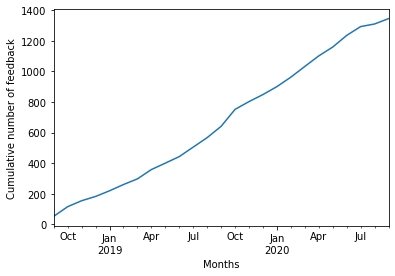

In [12]:
plt.figure()
(nb_per_months
    .cumsum()
    .plot())
plt.xlabel('Months')
plt.ylabel('Cumulative number of feedback')
plt.show()

Feedback number per topics

In [13]:
(grouped_by_topic
     .count()
     .sort_values('timestamp', ascending=False)
     .timestamp)

topic
Introduction to Galaxy Analyses                 588
Transcriptomics                                 220
Sequence analysis                               130
Metagenomics                                     72
Galaxy Server administration                     54
Epigenetics                                      47
Variant Analysis                                 38
Statistics and machine learning                  36
Assembly                                         34
Genome Annotation                                26
Proteomics                                       23
User Interface and Features                      15
Contributing to the Galaxy Training Material     14
Data Manipulation                                11
Computational chemistry                           7
Imaging                                           6
Metabolomics                                      5
Teaching and Hosting Galaxy training              3
User Interface and Data Manipulation              3
Ecolog

Top 10 tutorials with feedbacks

In [14]:
(df
    .groupby(by="tutorial")
    .count()
    .sort_values('timestamp', ascending=False)
    .timestamp
    .head(10))

tutorial
A short introduction to Galaxy                        330
Galaxy 101                                            106
Quality Control                                        99
From peaks to genes                                    68
Reference-based RNA-Seq data analysis                  67
Visualization of RNA-Seq results with Volcano Plot     32
Mapping                                                31
RNA-Seq reads to counts                                28
16S Microbial Analysis with mothur (extended)          25
NGS data logistics                                     25
Name: timestamp, dtype: int64

# Notes

In [15]:
def plot_note_histogram(s, title):
    plt.figure()
    s.plot(kind='barh', color='k', ylim=(0,5), xlim=(0,1), title=title)
    plt.xlabel('Proportion of feedback')
    plt.show()

In [16]:
notes = (notes
         .fillna(0.0)
         .astype(int)
         .rename(index = {0: 'No value'}))
# 1: emoji.emojize(':-1:', use_aliases=True)
# 5: emoji.emojize(':heart:', use_aliases=True)
notes

,All topics,Assembly,Climate,Computational chemistry,Contributing to the Galaxy Training Material,Data Manipulation,Development in Galaxy,Ecology,Epigenetics,Galaxy Server administration,...,Metagenomics,Proteomics,Sequence analysis,Statistics and machine learning,Teaching and Hosting Galaxy training,Transcriptomics,User Interface and Data Manipulation,User Interface and Features,Variant Analysis,Visualisation
No value,15,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,5,0,0,1,0
1,55,1,0,1,2,1,0,0,2,1,...,2,1,6,0,0,7,1,0,8,0
2,25,2,0,0,1,1,0,0,3,0,...,2,0,3,0,0,1,0,1,2,0
3,78,3,0,1,1,0,0,0,3,4,...,7,0,11,2,0,13,0,2,2,0
4,260,9,0,1,0,8,0,0,13,8,...,17,5,36,10,1,43,1,3,4,0
5,913,18,1,4,10,1,1,2,25,40,...,43,17,74,24,2,151,1,9,21,2


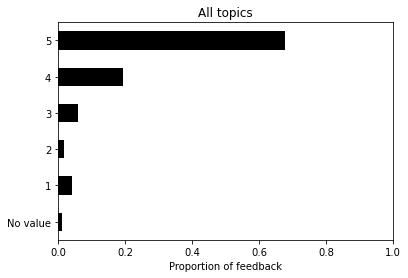

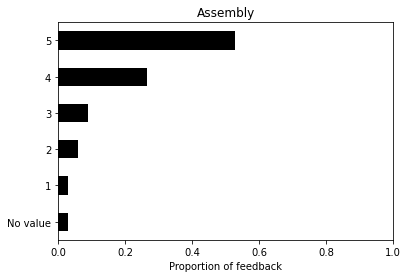

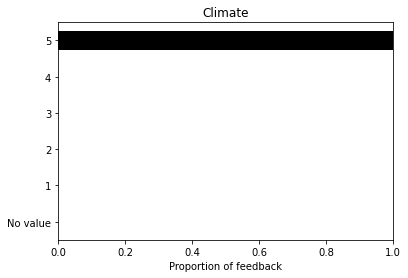

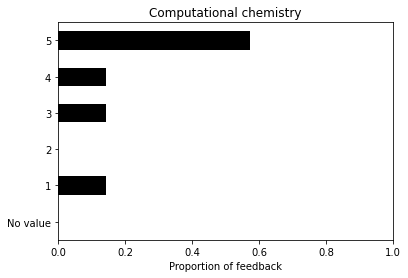

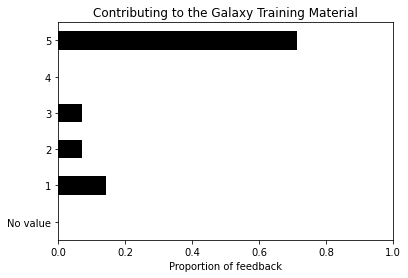

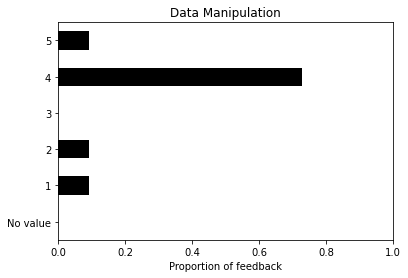

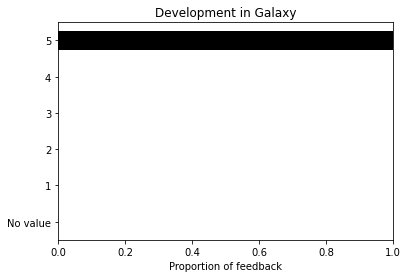

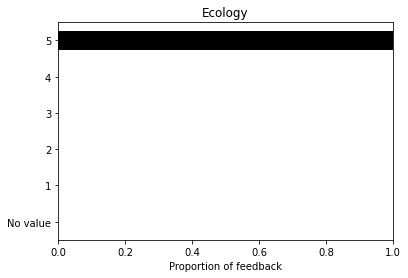

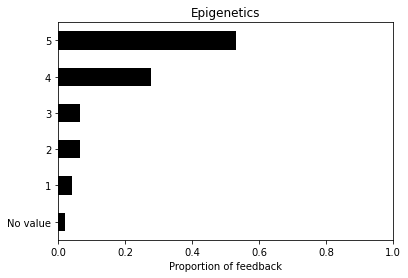

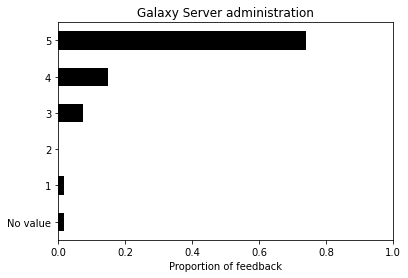

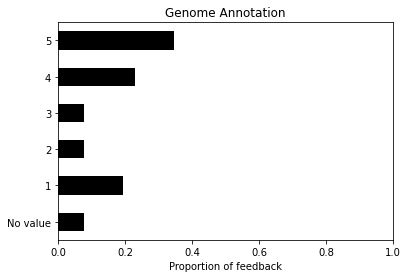

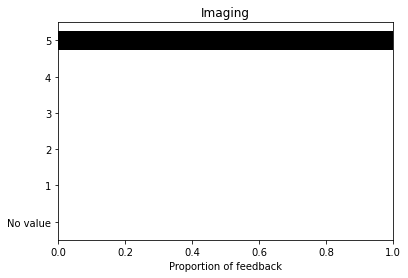

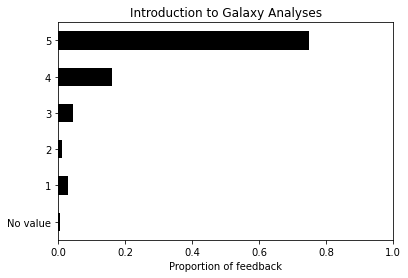

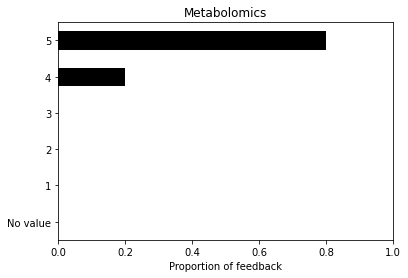

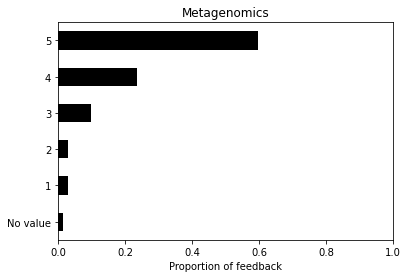

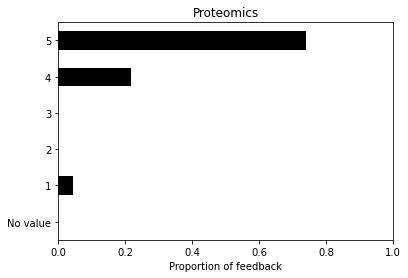

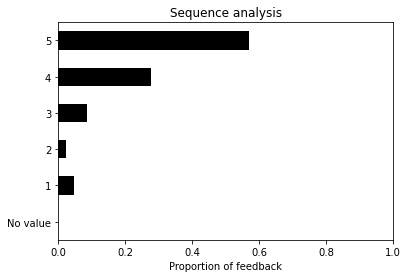

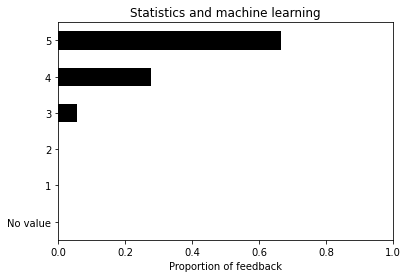

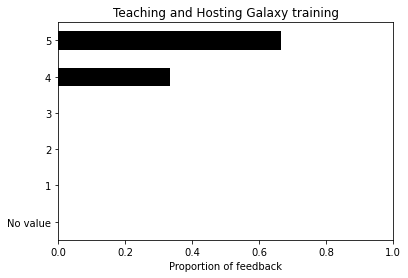

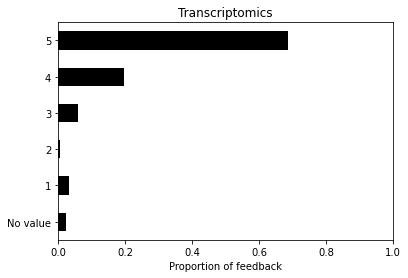

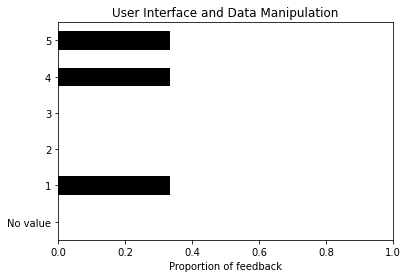

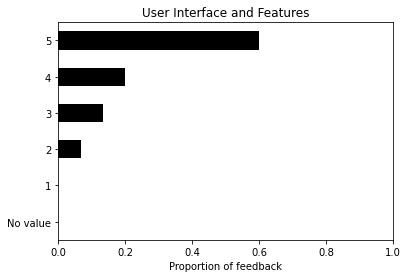

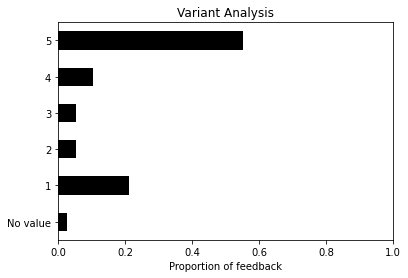

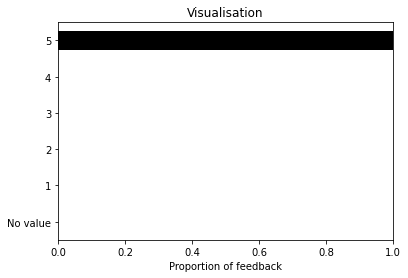

In [17]:
notes_prop = (notes/notes.sum().round(2))
for col in notes_prop.columns:
    plot_note_histogram(notes_prop[col], col)

In [18]:
notes_prop

,All topics,Assembly,Climate,Computational chemistry,Contributing to the Galaxy Training Material,Data Manipulation,Development in Galaxy,Ecology,Epigenetics,Galaxy Server administration,...,Metagenomics,Proteomics,Sequence analysis,Statistics and machine learning,Teaching and Hosting Galaxy training,Transcriptomics,User Interface and Data Manipulation,User Interface and Features,Variant Analysis,Visualisation
No value,0.011144,0.029412,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.021277,0.018519,...,0.013889,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.026316,0.0
1,0.040862,0.029412,0.0,0.142857,0.142857,0.090909,0.0,0.0,0.042553,0.018519,...,0.027778,0.043478,0.046154,0.000000,0.000000,0.031818,0.333333,0.000000,0.210526,0.0
2,0.018574,0.058824,0.0,0.000000,0.071429,0.090909,0.0,0.0,0.063830,0.000000,...,0.027778,0.000000,0.023077,0.000000,0.000000,0.004545,0.000000,0.066667,0.052632,0.0
3,0.057949,0.088235,0.0,0.142857,0.071429,0.000000,0.0,0.0,0.063830,0.074074,...,0.097222,0.000000,0.084615,0.055556,0.000000,0.059091,0.000000,0.133333,0.052632,0.0
4,0.193165,0.264706,0.0,0.142857,0.000000,0.727273,0.0,0.0,0.276596,0.148148,...,0.236111,0.217391,0.276923,0.277778,0.333333,0.195455,0.333333,0.200000,0.105263,0.0
5,0.678306,0.529412,1.0,0.571429,0.714286,0.090909,1.0,1.0,0.531915,0.740741,...,0.597222,0.739130,0.569231,0.666667,0.666667,0.686364,0.333333,0.600000,0.552632,1.0
